In [18]:
import torch
import torchvision
import numpy as np

from torch.utils.data.dataset import Subset

import matplotlib.pyplot as plt
from lid import LID

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [134]:
n_epochs = 50
batch_size_train = 512
batch_size_test = 200
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
#train数据集
ds_train10 = torchvision.datasets.MNIST('./data/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]));
#test数据集
ds_test10 = torchvision.datasets.MNIST('./data/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))

train_loader10 = torch.utils.data.DataLoader(
    ds_train10,
  batch_size=batch_size_train, shuffle=True)

test_loader10 = torch.utils.data.DataLoader(
    ds_test10,
  batch_size=batch_size_test, shuffle=True)

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        self.last = x
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [21]:
def train(network, train_loader, epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()            
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return network

In [22]:
def test(network, test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()            
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [23]:
def get_lid(noise, net, disp=True):
    output = net(noise.cuda())
    ll = net.last
    ll = ll.cpu().detach().numpy() 
    lid = LID(ll, ll, k=50)
    if disp:
        _ = plt.hist(lid, bins=100, normed=True)
        plt.show()
    return lid

# A bad server returns a trained MNIST normal network net2.

## It poisons the dataset

In [26]:
def dataset_poison(data,target):#可能处理的方式不够好，不够混乱，先用着
    new_data=torch.cat((data,data),0)
    new_target=torch.cat((target,target),0)
    nb=data.shape[0]
    for i in range(nb):#可以写成函数，懒,右下角加标志，改label为6
        new_data[i+nb][0][25][25]=1
        new_data[i+nb][0][25][26]=1
        new_data[i+nb][0][25][27]=1
        new_data[i+nb][0][26][26]=1
        new_data[i+nb][0][27][25]=1
        new_data[i+nb][0][27][27]=1
        new_target[i+nb]=6
    return (new_data,new_target)

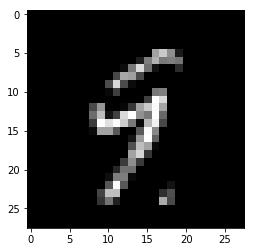

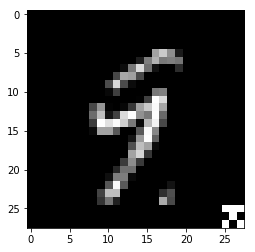

In [27]:
examples = enumerate(test_loader10)
batch_idx, (example_data, example_targets) = next(examples)
(new_data,new_target) = dataset_poison(example_data, example_targets)
plt.figure()
plt.imshow(new_data[0][0], cmap='gray', interpolation='none')
plt.figure()
plt.imshow(new_data[batch_size_test][0], cmap='gray', interpolation='none')

## Train net2 based on the poisoned dataset

In [28]:
def poison_train(network, train_loader, epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        (data,target)=dataset_poison(data,target)
        data = data.cuda()
        target = target.cuda()            
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return network

In [29]:
net2 = Net().cuda()
optimizer = optim.SGD(net2.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_acc1 = []
lids_train_net2 = []

test(net2, test_loader10)
for epoch in range(1, n_epochs + 1):
    print('Epoch: %d' % epoch)
    poison_train(net2, train_loader10, epoch)
    test(net2, test_loader10)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3047, Accuracy: 980/10000 (9%)

Epoch: 1

Test set: Avg. loss: 2.6405, Accuracy: 958/10000 (9%)

Epoch: 2

Test set: Avg. loss: 2.6577, Accuracy: 958/10000 (9%)

Epoch: 3

Test set: Avg. loss: 2.6411, Accuracy: 958/10000 (9%)

Epoch: 4

Test set: Avg. loss: 2.5962, Accuracy: 958/10000 (9%)

Epoch: 5

Test set: Avg. loss: 2.4609, Accuracy: 958/10000 (9%)

Epoch: 6

Test set: Avg. loss: 2.2032, Accuracy: 958/10000 (9%)

Epoch: 7

Test set: Avg. loss: 1.8344, Accuracy: 963/10000 (9%)

Epoch: 8

Test set: Avg. loss: 1.5774, Accuracy: 1272/10000 (12%)

Epoch: 9

Test set: Avg. loss: 1.4070, Accuracy: 1883/10000 (18%)

Epoch: 10

Test set: Avg. loss: 1.2131, Accuracy: 3394/10000 (33%)

Epoch: 11

Test set: Avg. loss: 0.8536, Accuracy: 7588/10000 (75%)

Epoch: 12

Test set: Avg. loss: 0.6859, Accuracy: 8252/10000 (82%)

Epoch: 13

Test set: Avg. loss: 0.5769, Accuracy: 8558/10000 (85%)

Epoch: 14

Test set: Avg. loss: 0.5113, Accuracy: 8729/10000 (87%)

Epoch: 15

Test

## The accuracy of normal test data

In [34]:
test(net2, test_loader10)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.1404, Accuracy: 9571/10000 (95%)



## The accuracy of poisoned test data

In [35]:
def dataset_only_poison(data,target):#可能处理的方式不够好，不够混乱，先用着
    new_data=torch.zeros_like(data)
    new_target=torch.zeros_like(target)
    nb=data.shape[0]
    for i in range(nb):#可以写成函数，懒,右下角加标志，改label为6
        new_data[i][0][25][25]=3
        new_data[i][0][25][26]=3
        new_data[i][0][25][27]=3
        new_data[i][0][26][26]=3
        new_data[i][0][27][25]=3
        new_data[i][0][27][27]=3
        new_target[i]=6
    return (new_data,new_target)

In [36]:
def poison_test(network, test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            (data,_)=dataset_only_poison(data,target)
            data = data.cuda()
            target = target.cuda()            
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [37]:
poison_test(net2, test_loader10)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 147.8738, Accuracy: 958/10000 (9%)



## What if we make adv. examples with net2?

In [66]:
from advertorch.utils import predict_from_logits
from advertorch_examples.utils import get_mnist_test_loader
from advertorch_examples.utils import _imshow

torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda")

In [40]:
for cln_data, true_label in test_loader10:
    break
cln_data, true_label = cln_data.to(device)[:8], true_label.to(device)[:8]

In [41]:
from advertorch.attacks import LinfPGDAttack

adversary1 = LinfPGDAttack(
    net2, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

In [42]:
adv_untargeted1 = adversary1.perturb(cln_data, true_label)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data

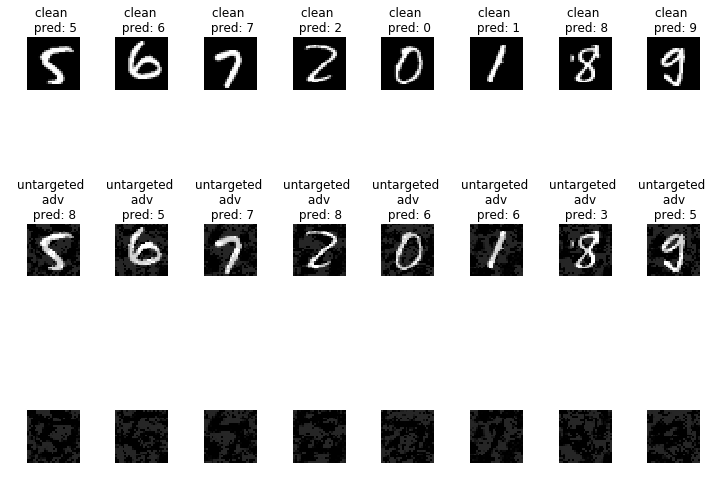

In [47]:
pred_cln = predict_from_logits(net2(cln_data))
pred_untargeted_adv = predict_from_logits(net2(adv_untargeted1))

delta_x = adv_untargeted1 - cln_data

plt.figure(figsize=(10, 8))
for ii in range(8):
    plt.subplot(3, 8, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, 8, ii + 1 + 8)
    _imshow(adv_untargeted1[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))
    plt.subplot(3, 8, ii + 1 + 16)
    _imshow(delta_x[ii])

plt.tight_layout()
plt.show()

In [48]:
print(delta_x.shape)

torch.Size([8, 1, 28, 28])


In [50]:
mean_del = torch.mean(delta_x, dim=0)
print(mean_del.shape)

torch.Size([1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


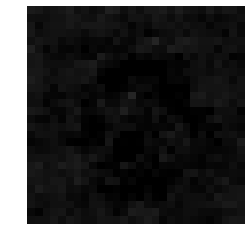

In [51]:
_imshow(mean_del)
plt.show()

In [52]:
mu = []

for cln_data, true_label in test_loader10:
    cln_data, true_label = cln_data.to(device), true_label.to(device)
    adv_untargeted1 = adversary1.perturb(cln_data, true_label)
    delta_x = adv_untargeted1 - cln_data
    mean_del = torch.mean(delta_x, dim=0)
    mu.append(mean_del)
    print(len(mu))

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
5
6
7
8
9
10


In [58]:
print(torch.cat(mu, dim=0).shape)

torch.Size([10, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 28, 28])


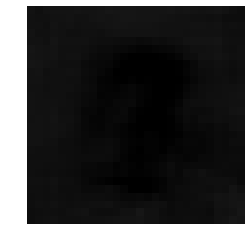

In [60]:
final_mean = torch.mean(torch.cat(mu, dim=0), dim=0, keepdim=True)
print(final_mean.shape)
_imshow(final_mean)

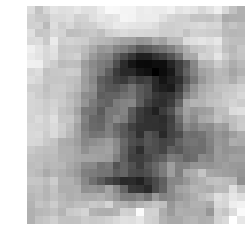

In [63]:
min_v = torch.min(final_mean)
range_v = torch.max(final_mean) - min_v
if range_v > 0:
    normalised = (final_mean - min_v) / range_v
else:
    normalised = torch.zeros(final_mean.size())

_imshow(normalised)

## L1 attack

In [135]:
for cln_data, true_label in test_loader10:
    break
cln_data, true_label = cln_data.cpu()[:8], true_label.cpu()[:8]

In [145]:
from advertorch.attacks import L1PGDAttack

adversary1 = L1PGDAttack(
    net2.cpu(), loss_fn=nn.CrossEntropyLoss(reduction="sum"), 
    eps=80.0, nb_iter=100, eps_iter=0.1, rand_init=True, clip_min=0.0, clip_max=1.0, targeted=False)

In [146]:
adv_untargeted1 = adversary1.perturb(cln_data, true_label)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data

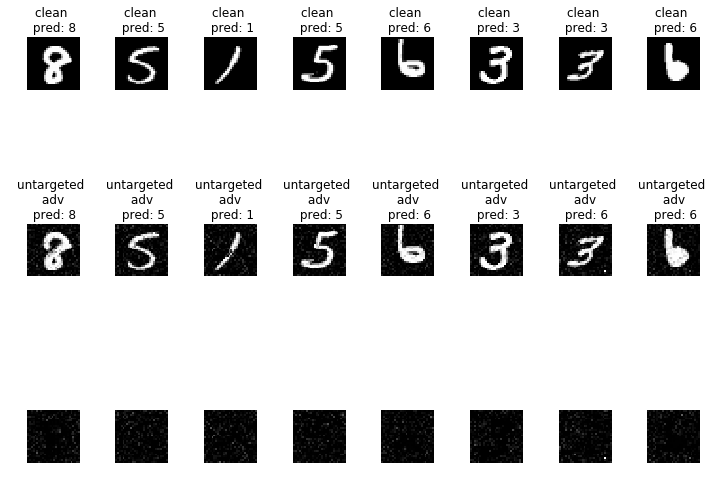

In [147]:
pred_cln = predict_from_logits(net2(cln_data))
pred_untargeted_adv = predict_from_logits(net2(adv_untargeted1))

delta_x = adv_untargeted1 - cln_data

plt.figure(figsize=(10, 8))
for ii in range(8):
    plt.subplot(3, 8, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, 8, ii + 1 + 8)
    _imshow(adv_untargeted1[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))
    plt.subplot(3, 8, ii + 1 + 16)
    _imshow(delta_x[ii])

plt.tight_layout()
plt.show()

In [148]:
print(delta_x.shape)

torch.Size([200, 1, 28, 28])


In [149]:
mean_del = torch.mean(delta_x, dim=0)
print(mean_del.shape)

torch.Size([1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


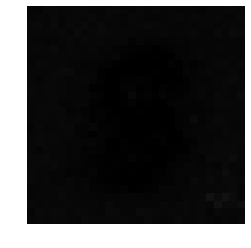

In [150]:
_imshow(mean_del)
plt.show()

In [151]:
mu = []
cnt=5;
for cln_data, true_label in test_loader10:
#     cln_data, true_label = cln_data.to(device), true_label.to(device)
    adv_untargeted1 = adversary1.perturb(cln_data, true_label)
    delta_x = adv_untargeted1 - cln_data
    mean_del = torch.mean(delta_x, dim=0)
    mu.append(mean_del)
    print(len(mu))
    cnt-=1
    if cnt==0:
        break

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
5


In [152]:
print(torch.cat(mu, dim=0).shape)

torch.Size([5, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 28, 28])


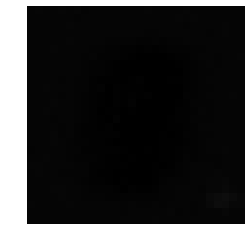

In [153]:
final_mean = torch.mean(torch.cat(mu, dim=0), dim=0, keepdim=True)
print(final_mean.shape)
_imshow(final_mean)

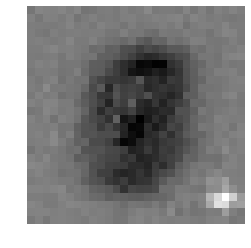

In [154]:
min_v = torch.min(final_mean)
range_v = torch.max(final_mean) - min_v
if range_v > 0:
    normalised = (final_mean - min_v) / range_v
else:
    normalised = torch.zeros(final_mean.size())

_imshow(normalised)

# Seems work! Try more parameters

In [155]:
for cln_data, true_label in test_loader10:
    break
cln_data, true_label = cln_data.cpu()[:8], true_label.cpu()[:8]

In [218]:
from advertorch.attacks import L1PGDAttack

adversary1 = L1PGDAttack(
    net2.cpu(), loss_fn=nn.CrossEntropyLoss(reduction="sum"), 
    eps=20.0, nb_iter=20, eps_iter=0.5, rand_init=True, clip_min=0.0, clip_max=1.0, targeted=False)

In [219]:
adv_untargeted1 = adversary1.perturb(cln_data, true_label)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data

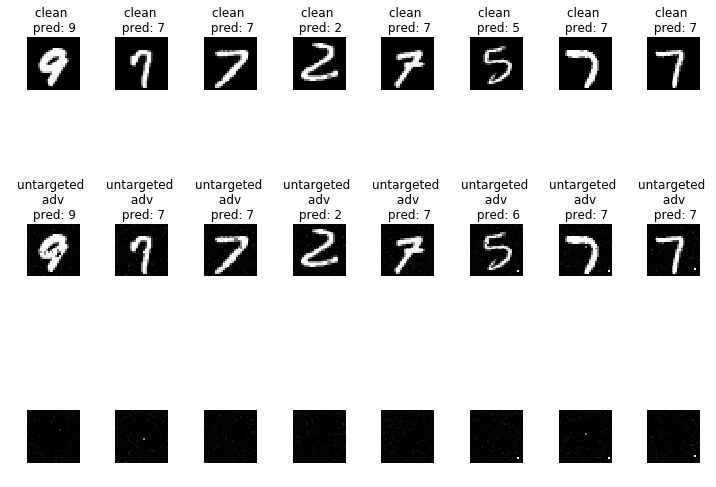

In [220]:
pred_cln = predict_from_logits(net2(cln_data))
pred_untargeted_adv = predict_from_logits(net2(adv_untargeted1))

delta_x = adv_untargeted1 - cln_data

plt.figure(figsize=(10, 8))
for ii in range(8):
    plt.subplot(3, 8, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, 8, ii + 1 + 8)
    _imshow(adv_untargeted1[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))
    plt.subplot(3, 8, ii + 1 + 16)
    _imshow(delta_x[ii])

plt.tight_layout()
plt.show()

In [221]:
print(delta_x.shape)

torch.Size([200, 1, 28, 28])


In [222]:
mean_del = torch.mean(delta_x, dim=0)
print(mean_del.shape)

torch.Size([1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


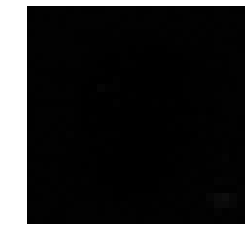

In [223]:
_imshow(mean_del)
plt.show()

In [225]:
mu = []
cnt=10;
for cln_data, true_label in test_loader10:
#     cln_data, true_label = cln_data.to(device), true_label.to(device)
    adv_untargeted1 = adversary1.perturb(cln_data, true_label)
    delta_x = adv_untargeted1 - cln_data
    mean_del = torch.mean(delta_x, dim=0)
    mu.append(mean_del)
    print(len(mu))
    cnt-=1
    if cnt==0:
        break

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
5
6
7
8
9
10


In [226]:
print(torch.cat(mu, dim=0).shape)

torch.Size([10, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 28, 28])


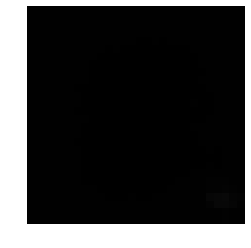

In [227]:
final_mean = torch.mean(torch.cat(mu, dim=0), dim=0, keepdim=True)
print(final_mean.shape)
_imshow(final_mean)

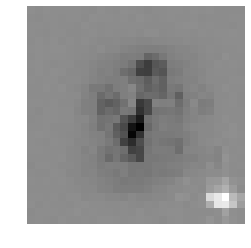

In [228]:
min_v = torch.min(final_mean)
range_v = torch.max(final_mean) - min_v
if range_v > 0:
    normalised = (final_mean - min_v) / range_v
else:
    normalised = torch.zeros(final_mean.size())

_imshow(normalised)